# Goals

#### Predict Gender and age in given groups based on the datasets provided 
These datasets come in csv files connected by different identification keys. 

# Understand the data
This is crucial! There are basic explanations on the competitions [website](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/data). Here is the data connection diagramm given:
![Data diagramm](data_tree.png)

We also already now that the company names are provided in chinese, which is not particularly helpful. Then, we see that the apps already are categorised, which is handy. However, doubt is present that the variable can be used out-of-the box.

In [2]:
# Set input dir
import sys
# perform imports so that we can use single cells w/o worrying about imports
import pandas as pd
from pandas import DataFrame as df
import IPython as ip

import seaborn as sns
sns.set(color_codes=True)
sns.set_context('poster',rc={"figure.figsize": (24, 10)})
sns.set_style('ticks')

%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
sys.path.append("/home/mschlupp/pythonTools")
tmp = %pwd
files_dir = tmp + "/files/" 

#### Load some nice colors from [my github](https://github.com/mschlupp/pythonTools/tree/master/plotting).
Then delete a few lines of the original file to make the code a bit leaner.

In [4]:
# %load '/home/mschlupp/pythonTools/plotting/nice_colors.py'

'''
Color dictionaries from 
http://tableaufriction.blogspot.de/2012/11/finally-you-can-use-tableau-data-colors.html
'''

Tableau10_Medium = { 
	"blue"   : (114/255.,158/255.,206/255.),
	"orange" : (255/255.,158/255.,74/255.),
	"green"  : (103/255.,191/255.,92/255.),
	"red"    : (237/255.,102/255.,93/255.),
	"purple" : (173/255.,139/255.,201/255.),
	"brown"  : (168/255.,120/255.,110/255.),
	"pink"   : (237/255.,151/255.,202/255.),
	"gray"   : (162/255.,162/255.,162/255.),
	"olive"  : (205/255.,204/255.,93/255.),
	"cyan"   : (109/255.,204/255.,218/255.)
}

ColorBlind10 = {
	"azure"        : (0./255.,107./255.,164/255.),
	"orange"       : (255./255.,128./255.,14/255.),
	"grey_medium"  : (171./255.,171./255.,171/255.),
	"grey_dark"    : (89./255.,89./255.,89/255.),
	"blue_medium"  : (95./255.,158./255.,209/255.),
	"orange_dark"  : (200./255.,82./255.,0/255.),
	"grey"         : (137./255.,137./255.,137/255.),
	"blue_light"   : (162./255.,200./255.,236/255.),
	"orange_light" : (255./255.,188./255.,121/255.),
	"grey_light"   : (207./255.,207./255.,207/255.)
}

We left of the first notebook, `1_understand_data`, with a merged data file. We will load it first.

In [5]:
traintest_phone = pd.read_csv(files_dir+'traintest_phone.csv',index_col=0)
traintest_phone.head(2)

,age,device_id,gender,group,isTrain,phone_brand,device_model
0,35,-8076087639492063270,M,M32-38,1,小米,MI 2
1,35,-2897161552818060146,M,M32-38,1,小米,MI 2


In [6]:
# Now we load the events data
events = pd.read_csv(files_dir+'events.csv')
events.head(2)

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97


In [7]:
# load other functions from my github, and delete lines.
# %load /home/mschlupp/pythonTools/utilities.py
'''
Module containing small general helper functions
'''

def showUniques(df):
		"""
		Helper function that shows unique entries per DataFrame column.

		Arguments:
		df: the pandas DataFrame in question.
		"""
		
		import pandas as pd
		from pandas import DataFrame 

		print("Number of rows: ", len(df))
		print("Number of unique values per column: ")
		for col in df.columns:
				print("Column {}: ".format(col), df[col].nunique())


In [8]:
print('gender: ')
showUniques(traintest_phone)
print('=======================','\nevents: ')
showUniques(events)

gender: 
Number of rows:  186716
Number of unique values per column: 
Column age:  86
Column device_id:  186716
Column gender:  3
Column group:  13
Column isTrain:  2
Column phone_brand:  131
Column device_model:  1599
events: 
Number of rows:  3252950
Number of unique values per column: 
Column event_id:  3252950
Column device_id:  60865
Column timestamp:  588125
Column longitude:  3588
Column latitude:  3086


In [9]:
traintest_phone.isTrain[traintest_phone.device_id.isin(events.device_id)].describe()

count    58503.000000
mean         0.398424
std          0.489578
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: isTrain, dtype: float64

In [10]:
# being paranoid again...
train = pd.read_csv('files/gender_age_train.csv')
test = pd.read_csv('files/gender_age_test.csv')

In [11]:
tr = train.device_id.isin(events.device_id)
te = test.device_id.isin(events.device_id)

In [12]:
print(tr.value_counts())#.apply(lambda x: x/len(tr.index)))
print(te.value_counts())#.apply(lambda x: x/len(te.index)))

False    51336
True     23309
Name: device_id, dtype: int64
False    76877
True     35194
Name: device_id, dtype: int64


This comes as a surprise. Only ~31% of the `device_id`s have event information available. At least the percentage is basically the same in the training and testing set.

Can we learn something from this?

In [13]:
try:
    traintest_phone['hasEvents'] = 1 if traintest_phone.device_id.isin(events.device_id) else 0
except ValueError:
    print('This does not seem to work. :(')
    traintest_phone['hasEvents'] = 0
    traintest_phone.hasEvents[traintest_phone.device_id.isin(events.device_id)] = 1
    

This does not seem to work. :(


/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
traintest_phone.head(3)

,age,device_id,gender,group,isTrain,phone_brand,device_model,hasEvents
0,35,-8076087639492063270,M,M32-38,1,小米,MI 2,0
1,35,-2897161552818060146,M,M32-38,1,小米,MI 2,0
2,35,-8260683887967679142,M,M32-38,1,小米,MI 2,1


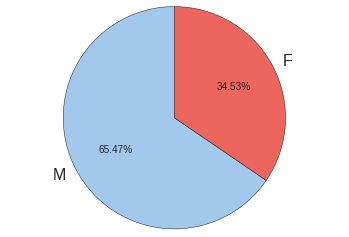

In [15]:
plt.pie(traintest_phone.gender[(traintest_phone.hasEvents==1) & (traintest_phone.isTrain==1)].value_counts(),
       colors=[ColorBlind10['blue_light'],Tableau10_Medium['red']],
       labels=traintest_phone.gender[traintest_phone.isTrain==1].value_counts().index, autopct='%2.2f%%', startangle=90);
plt.axis('equal');


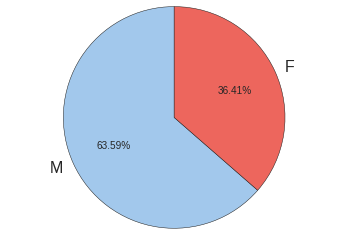

In [16]:
plt.pie(traintest_phone.gender[(traintest_phone.hasEvents==0) & (traintest_phone.isTrain==1)].value_counts(),
       colors=[ColorBlind10['blue_light'],Tableau10_Medium['red']],
       labels=traintest_phone.gender[traintest_phone.isTrain==1].value_counts().index, autopct='%2.2f%%', startangle=90);
plt.axis('equal');

Ok, no big differents in gender (original relations: 64.18% male and 35.82% female). How about age?

/home/mschlupp/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


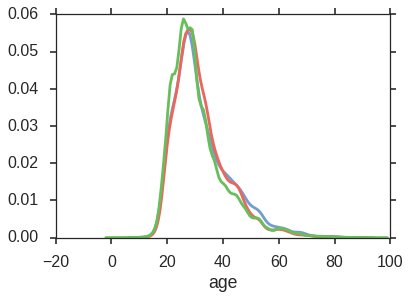

In [17]:
sns.distplot(traintest_phone.age[(traintest_phone.isTrain==1) 
                                 & (traintest_phone.hasEvents==1)
                                & (traintest_phone.gender=='F')],
            color=Tableau10_Medium['blue'], hist=False,
            bins=80);

sns.distplot(traintest_phone.age[(traintest_phone.isTrain==1) 
                                 & (traintest_phone.hasEvents==1)
                                & (traintest_phone.gender=='M')],
            color=Tableau10_Medium['red'], hist=False,
            bins=80);

sns.distplot(traintest_phone.age[(traintest_phone.isTrain==1)
                                 & (traintest_phone.hasEvents==0)],
            color=Tableau10_Medium['green'], hist=False,
            bins=80);


Only very slight differences.

In [18]:
print(len(events))
events.head(2)

3252950


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97


We can probably learn something from the number of events per `device_id`.

In [19]:
evts = events.groupby('device_id')

In [20]:
nhits = evts.event_id.count()
nhits.head(4)

device_id
-9222956879900151005    65
-9222661944218806987     8
-9222399302879214035    10
-9221825537663503111    99
Name: event_id, dtype: int64

In [21]:
nhits[-9222661944218806987]

8

In [22]:
indx = traintest_phone.device_id[traintest_phone.device_id.isin(events.device_id)]
indx.head(2)

2    -8260683887967679142
11    7477216237379271436
Name: device_id, dtype: int64

In [23]:
print(len(indx),len(nhits))

58503 60865


In [24]:
traintest_phone['nEvts']=0 # first set all nEvts to 0 as most have no event info available

In [25]:
# Now drop all the device_ids that are not in the training or test set
nhits = nhits[nhits.index.isin(traintest_phone.device_id)]
len(nhits)

58503

In [52]:
for i,x in enumerate(traintest_phone.iloc[indx.index].iterrows()):
    #print(x)
    traintest_phone.nEvts[x[0]]=nhits[x[1]['device_id']]
    if i % 5001 == 0:
        print(x[1]['nEvts'], x[1]['device_id'])
        print(float(i)/len(indx)*100, " percent done.")

/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


1 -8260683887967679142
0.0  percent done.
0 2229782027650717857
8.54827957540639  percent done.
0 -7478158881594228553
17.09655915081278  percent done.
0 -7887038045275129664
25.644838726219167  percent done.
0 -6243601313763071956
34.19311830162556  percent done.
0 -8300883621702907742
42.74139787703194  percent done.
0 1349601398804316935
51.28967745243833  percent done.
0 596045045353163474
59.83795702784472  percent done.
0 2252924856702561523
68.38623660325112  percent done.
0 5515675028870564447
76.9345161786575  percent done.
0 -4543791874687544846
85.48279575406389  percent done.
0 4516975590551813688
94.03107532947028  percent done.


### Further ideas:
use mean & spread of the latitude and longitude. 

In [63]:
nhits[-9222661944218806987]

8

In [76]:
traintest_phone.to_csvnfiles_diriririrhone.to_csv(files_dir+'traintest_phone_evts.csv')

In [84]:
len(evts.longitude.mean())

60865

In [91]:
# calculate mean and variance of longitude and latitude
# reduce to relevant device_ids 

long_mean = evts.longitude.mean()
long_mean = long_mean[long_mean.index.isin(traintest_phone.device_id)]
long_var = evts.longitude.var()
long_var = long_var[long_var.index.isin(traintest_phone.device_id)]

lat_mean = evts.latitude.mean()
lat_mean = lat_mean[lat_mean.index.isin(traintest_phone.device_id)]
lat_var = evts.latitude.var()
lat_var = lat_var[lat_var.index.isin(traintest_phone.device_id)]


In [93]:
# Give default values our new values
traintest_phone['longitude_mean'] =-1
traintest_phone['longitude_variance'] =-1
traintest_phone['latitude_mean'] =-1
traintest_phone['latitude_variance'] =-1

In [112]:
# set values to mean and var values

traintest_phone.longitude_mean.iloc[indx.index] = [long_mean[x] for x in indx]
traintest_phone.longitude_variance.iloc[indx.index] = [long_var[x] for x in indx]
traintest_phone.latitude_mean.iloc[indx.index] = [lat_mean[x] for x in indx]
traintest_phone.latitude_variance.iloc[indx.index] = [lat_var[x] for x in indx]

/home/mschlupp/anaconda3/lib/python3.5/site-packages/pandas-0.17.1-py3.5-linux-x86_64.egg/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [199]:
traintest_phone.latitude_variance[traintest_phone.latitude_variance.isnull()]=-1
traintest_phone.longitude_variance[traintest_phone.longitude_variance.isnull()]=-1

/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Format the timestamp
First, we split the timestamp into day and time. 

This doesn't make sense right now. It is not yet a variable that can be grouped to device id.
So first we add these to the events data.

In [202]:
events['day'] = events.timestamp.apply(lambda x: x.split()[0])
events['time'] = events.timestamp.apply(lambda x: x.split()[1])

In [203]:
events.day.unique()

array(['2016-05-01', '2016-04-30', '2016-05-02', '2016-05-03',
       '2016-05-04', '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08'], dtype=object)

Ok there are only nine days, lets translate these into weekdays:
   * 2016-04-30: Saturday
   * 2016-05-01: Sunday
   * 2016-05-02: Monday
   * 2016-05-03: Tuesday
   * 2016-05-04: Wednesday
   * 2016-05-05: Thursday
   * 2016-05-06: Friday
   * 2016-05-07: Saturday
   * 2016-05-08: Sunday

In [204]:
events.day[events.day=='2016-04-30'] = 'Sat';
events.day[events.day=='2016-05-01'] = 'Sun';
events.day[events.day=='2016-05-03'] = 'Tue';
events.day[events.day=='2016-05-04'] = 'Wed';
events.day[events.day=='2016-05-05'] = 'Thu';
events.day[events.day=='2016-05-06'] = 'Fri';
events.day[events.day=='2016-05-07'] = 'Sat';
events.day[events.day=='2016-05-08'] = 'Sun';


/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mschlupp/anaconda3/l

In [211]:
# Split the time stamps into categories of hours

events['hour'] = events.time.apply(lambda x: x.split(sep=':')[0])

In [212]:
#tranform string to int feature with sklearn LabelEncoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
f=le.fit(events.hour)

In [213]:
events.hour = f.transform(events.hour)

In [214]:
events.tail()

,event_id,device_id,timestamp,longitude,latitude,day,time,hour
3252945,3252946,-8995272658520685777,2016-05-07 23:14:17,0.00,0.00,Sat,23:14:17,23
3252946,3252947,6790350461641275817,2016-05-07 23:14:08,120.65,27.78,Sat,23:14:08,23
3252947,3252948,7111660304904287709,2016-05-07 23:35:33,121.40,31.18,Sat,23:35:33,23
3252948,3252949,2786044170600788970,2016-05-07 23:36:03,111.19,31.29,Sat,23:36:03,23
3252949,3252950,3315513013457872370,2016-05-07 23:20:08,112.99,28.23,Sat,23:20:08,23


In [215]:
events.to_csv(files_dir+'events_day_hour.csv')